Samuel Díaz    26472702\
Efrain Sánchez 27223322

#Installations


In [2]:
!pip install sklearn
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=e77cc75caa181ef35d3b88729f7f5b1d64eccb3cc937a8ebd78c031a38ad2004
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 799 kB 34.5 MB/s 
     |████████████████████████████████| 125 kB 79.9 MB/s 
     |████████████████████████████████| 512 kB 51.1 MB/s 


# Imports

In [3]:
# import the tools we need
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm


# Downloading Dataset

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"efransnchez","key":"2b6e91f5ae1e3475d2291f78d6990e2d"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

100% 750M/750M [00:36<00:00, 22.5MB/s]
100% 750M/750M [00:36<00:00, 21.7MB/s]


In [7]:
!unzip -qq stanford-dogs-dataset.zip

In [8]:
dataset = ImageFolder('./images/Images')

In [9]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_')) # Getting Labels from Filenames

for n in dataset.classes:
    breeds.append(rename(n))

# Splitting and Transforming Data

In [10]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [11]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

n02100583-vizsla
<class 'PIL.Image.Image'>


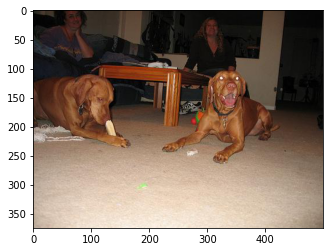

In [12]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In this step we'll create a custom dataset class that we will be using to apply a couple preprocessing transformations to our images. This includes randomly flipping, rotating and resizing our images for data augmentation. We also apply a transformation to normalize our images according to the optimal parameters for ImageNet.

In [13]:
class img_dataset(Dataset):
    def __init__(self,dataframe,transform=None,test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.test = test
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0])
        if self.transform:
            x = self.transform(x)
        if self.test:
            return x
        else:
            y = self.dataframe.iloc[index,1]
            return x,y
        
    def __len__(self):
        return self.dataframe.shape[0]

In [14]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   # This value is standard for all ImageNet datasets

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.21),
    transforms.RandomRotation(degrees=27),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats, inplace=True)
    
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [15]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [16]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

In [17]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

# Defining the model

In [23]:
# Setting up gpu
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

We'll be using a creating a model based off of the pretrained ResNet50 model. We're adding two Linear layers, as well as freezing all the previous layers so the weight don't get messy when retraining.

In [24]:
class net50(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net50,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

In [25]:
res = torchvision.models.resnet50(pretrained=True)
for param in res.parameters():    ## Freezing layers
    param.requires_grad=False

model1 = net50(base_model=res, base_out_features=res.fc.out_features, num_classes=120)

In [26]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [27]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [28]:
# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model1, device);

# Fitting Model

The actual fitting of the model.

In [29]:
# Print the result of 1 epoch
def print_epoch_result(train_loss,train_acc,val_loss,val_acc):
    print('loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(train_loss,
                                                                              train_acc,
                                                                              val_loss,
                                                                              val_acc))
# Main Training function
def train_model(model, cost_function, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Metrics object
    train_acc_object = torchmetrics.Accuracy(task='multiclass',num_classes=120)
    val_acc_object = torchmetrics.Accuracy(task='multiclass',num_classes=120)
    
    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # Training
        train_sub_losses = []
        model.train()
        for x,y in train_dl:
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            #y_hat = y_hat.transpose(0,1)
            loss.backward()
            optimizer.step()
            # update loss sublist
            train_sub_losses.append(loss.item())
            # update accuracy object
            train_acc_object(y_hat.cpu(),y.cpu())
            
        # Validation
        val_sub_losses = []
        model.eval()
        for x,y in val_dl:
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            val_acc_object(y_hat.cpu(),y.cpu())
            
        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))
        
        # Update the accuracy list and reset the metrics object 
        train_epoch_acc = train_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        train_acc.append(train_epoch_acc)
        val_acc.append(val_epoch_acc)
        train_acc_object.reset()
        val_acc_object.reset()
        
        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),train_epoch_acc,np.mean(val_sub_losses),val_epoch_acc)
        
    print('Finish Training.')
    return train_losses, train_acc, val_losses, val_acc

In [30]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model1.parameters() if param.requires_grad], lr=0.0003)

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

train_losses, train_acc, val_losses, val_acc = train_model(model=model1, 
                                                           cost_function=cost_function, 
                                                           optimizer=optimizer,
                                                           num_epochs=num_epochs)

---------------
Start training 1/10
---------------
loss: 2.201, acc: 0.501, val_loss: 1.039, val_acc: 0.688
---------------
Start training 2/10
---------------
loss: 1.000, acc: 0.721, val_loss: 0.817, val_acc: 0.756
---------------
Start training 3/10
---------------
loss: 0.853, acc: 0.746, val_loss: 0.805, val_acc: 0.764
---------------
Start training 4/10
---------------
loss: 0.776, acc: 0.764, val_loss: 0.758, val_acc: 0.769
---------------
Start training 5/10
---------------
loss: 0.736, acc: 0.776, val_loss: 0.754, val_acc: 0.760
---------------
Start training 6/10
---------------
loss: 0.685, acc: 0.792, val_loss: 0.779, val_acc: 0.754
---------------
Start training 7/10
---------------
loss: 0.653, acc: 0.803, val_loss: 0.730, val_acc: 0.772
---------------
Start training 8/10
---------------
loss: 0.619, acc: 0.808, val_loss: 0.753, val_acc: 0.769
---------------
Start training 9/10
---------------
loss: 0.597, acc: 0.815, val_loss: 0.717, val_acc: 0.778
---------------
Sta

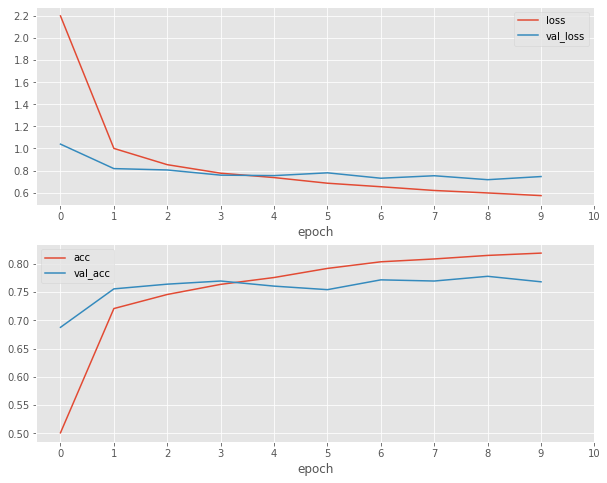

In [31]:
def plot_result(train_loss,val_loss,train_acc,val_acc):
    plt.style.use('ggplot')
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
    ax1.plot(train_loss,label='loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.legend()
    ax1.set_xlabel('epoch')
    ax1.set_xticks(range(0,num_epochs+1))
    ax2.plot(train_acc, label='acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.legend()
    ax2.set_xlabel('epoch')
    ax2.set_xticks(range(0,num_epochs+1))
    plt.show()
plot_result(train_losses,val_losses, train_acc,  val_acc)

In [32]:
torch.save(model1.state_dict(), "model.zip")